<a href="https://colab.research.google.com/github/fatenchtioui/Projet/blob/main/TP5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models

# Connect to Google Drive (optional)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset_path = '/content/drive/MyDrive/train_cancer'

# Data generators
**Data generators** in the context of machine learning, and particularly deep learning, are a way to efficiently load and preprocess data in batches during training. They are commonly used when working with large datasets that may not fit into memory all at once. Data generators are crucial for training deep learning models in a memory-efficient manner.

The key concepts related to data generators:

1. **Batch Loading:**
Data generators load a small batch of data at a time during each iteration of training. This is in contrast to loading the entire dataset into memory at once, which may not be feasible for large datasets.

2. **Online Data Augmentation:**
Data generators often include functionality for online data augmentation. Augmentation involves applying random transformations to the input data (e.g., rotation, zoom, flip) to increase the diversity of the training set and improve the model's generalization.

3. **Memory Efficiency:**
By loading and processing data in batches, data generators allow training on datasets that are larger than the available memory. This is especially important when dealing with high-resolution images or extensive datasets.

4. **Integration with Model Training:**
Data generators seamlessly integrate with training loops. They provide batches of input samples along with their corresponding labels, allowing the model to be trained in an iterative fashion.

5. **Keras ImageDataGenerator:**
In the context of deep learning with TensorFlow and Keras, the ImageDataGenerator class is commonly used for creating data generators. It performs real-time data augmentation on images and prepares them for training. The generator can be easily integrated into the fit method of a Keras model.

In [ ]:
# Set up data generators
#This line sets the batch size for training and validation data.
#The batch size is the number of samples that will be used in each iteration of training.
#It's a hyperparameter that affects the efficiency of training and the memory requirements.
#Common values are powers of 2, like 32, 64, etc.
batch_size = 32

train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
#Instance of the ImageDataGenerator class is created.
#This generator will be responsible for loading and augmenting the training data.
#The rescale=1./255 parameter scales the pixel values of the images to the range [0, 1].
#The validation_split=0.2 parameter specifies that 20% of the data will be used for validation.
train_generator = train_datagen.flow_from_directory(
    #The flow_from_directory method generates a data generator for the training set.
    #It expects the path to a directory containing subdirectories for each class, where the actual image data is stored.
    dataset_path,
    target_size=(224, 224), #The size to which all images will be resized.
    batch_size=batch_size,
    class_mode='binary', #Since this is a Binary classification. For multiple classes classification, 'categorical' is chosen.
    subset='training' # Indicates that this is the training subset of the data.
)

validation_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'
)

Found 216 images belonging to 2 classes.
Found 54 images belonging to 2 classes.


In [ ]:
#Build the VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
#VGG16 is a pre-trained deep learning model architecture that achieved excellent performance on the ImageNet dataset.
#weights='imagenet' specifies that the model should be initialized with weights pre-trained on the ImageNet dataset.
#include_top=False means that the final fully connected layer (top layer) of the VGG16 model,
#which is responsible for classification into ImageNet classes, will not be included.
#We're going to add our own classification layers.

model = models.Sequential()
model.add(base_model)
# Add the VGG16 base model to the Sequential model
#This serves as the feature extractor from the input images
model.add(layers.Flatten())
# Flatten the output of the VGG16 base model
model.add(layers.Dense(256, activation='relu'))
# Add a dropout layer for regularization
#
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))
#model.add(layers.Dense(train_generator.num_classes, activation='softmax')) for multiclass

58889256/58889256 [==============================] - 0s 0us/step


# Freezing layers
Dans le contexte de l'apprentissage par transfert(transfer learning), il est courant d'utiliser un modèle pré-entraîné (tel que VGG16, dans le cas présent) et de l'affiner ensuite pour une tâche spécifique.
* **Geler les couches** ( freezing layers) signifie que vous empêchez la mise à jour des poids de ces couches pendant l'apprentissage.

En définissant les couches comme non entraînables, vous conservez les connaissances pré-entraînées capturées par ces couches.

Cela est utile lorsque vous disposez de peu de données étiquetées pour votre tâche spécifique, car les caractéristiques apprises par le modèle pré-entraîné sur un grand base de données (tel qu'ImageNet) peuvent être utiles pour des tâches similaires.

Le gel de toutes les couches d'un modèle pré-entraîné dépend de votre cas d'utilisation spécifique et de la taille de votre ensemble de données. Voici quelques éléments à prendre en compte :

1. **Petits ensembles de données :**

Si vous disposez d'un petit ensemble de données, il est courant de geler toutes les couches et de ne former que quelques couches supplémentaires au-dessus du modèle pré-entraîné. En effet, la formation d'un réseau neuronal profond à partir de zéro sur un petit ensemble de données peut entraîner un surajustement.
2. **Grands ensembles de données :**

Si vous disposez d'un ensemble de données important et diversifié, vous pouvez avoir suffisamment de données pour affiner non seulement les couches supérieures, mais aussi certaines des couches antérieures du modèle pré-entraîné. Cela peut s'avérer utile pour l'apprentissage de caractéristiques spécifiques à une tâche.
3. **Similitude des tâches :**

La décision de geler toutes les couches ou d'affiner certaines couches dépend également du degré de similitude entre votre tâche et celle pour laquelle le modèle pré-entraîné a été formé à l'origine. Si les tâches sont très similaires, il peut s'avérer utile d'ajuster plus de couches.

4. **Ressources informatiques :**

La formation de toutes les couches d'un réseau neuronal profond peut s'avérer coûteuse sur le plan informatique. Si vos ressources informatiques sont limitées, geler la plupart des couches et n'en former que quelques-unes peut être une approche pratique.

In [ ]:
# Freeze the VGG16 layers
for layer in base_model.layers:
    layer.trainable = False
# if you don't want to freez all the layers :

#fine_tune_at = 15  # Choose the number based on your requirements

# Freeze all layers up to the specified layer
#for layer in base_model.layers[:fine_tune_at]:
 #   layer.trainable = False

In [ ]:
# Compile the model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy', #loss='categorical_crossentropy' for multiclass classification
    metrics=['accuracy']
)

In [ ]:
# Display model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 21137729 (80.63 MB)
Trainable params: 6423041 (24.50 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [ ]:
epochs = 3
#After training is complete, the fit method returns a History object. This object contains information about the training process,
#such as training loss, training accuracy, validation loss, and validation accuracy at each epoch.
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    #In Keras, during the training process, one epoch is completed when the model has iterated over the entire training dataset once.
    #However, the dataset is not processed in its entirety at once but rather in batches.
    #steps_per_epoch specifies the number of batches to go through before considering one epoch finished.
    #It's a way to define when to move to the next epoch during training.
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)

Epoch 1/3
6/6 [==============================] - 163s 26s/step - loss: 2.1131 - accuracy: 0.8533 - val_loss: 0.9394 - val_accuracy: 0.8750
Epoch 2/3
6/6 [==============================] - 148s 25s/step - loss: 0.5697 - accuracy: 0.8438 - val_loss: 0.4350 - val_accuracy: 0.9062
Epoch 3/3
6/6 [==============================] - 164s 28s/step - loss: 0.4218 - accuracy: 0.8750 - val_loss: 0.3216 - val_accuracy: 0.9062


In [ ]:
model.save('/content/drive/MyDrive/trained models/model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


H'extension **.h5** dans le nom de fichier "model.h5" indique que le modèle est enregistré dans le format de fichier Hierarchical Data Format (HDF5). HDF5 est un format de fichier et un ensemble d'outils de gestion de données complexes, couramment utilisé pour stocker de grandes quantités de données numériques, y compris les poids, les biais et l'architecture des modèles de réseaux neuron

In [ ]:
# Evaluate the model
score = model.evaluate(validation_generator, steps=validation_generator.samples // batch_size)
print(f'Test Loss: {score[0]}, Test Accuracy: {score[1]}')

1/1 [==============================] - 21s 21s/step - loss: 0.3334 - accuracy: 0.9062
Test Loss: 0.3334229588508606, Test Accuracy: 0.90625


Text(0.5, 1.0, 'Training and Validation Accuracy')

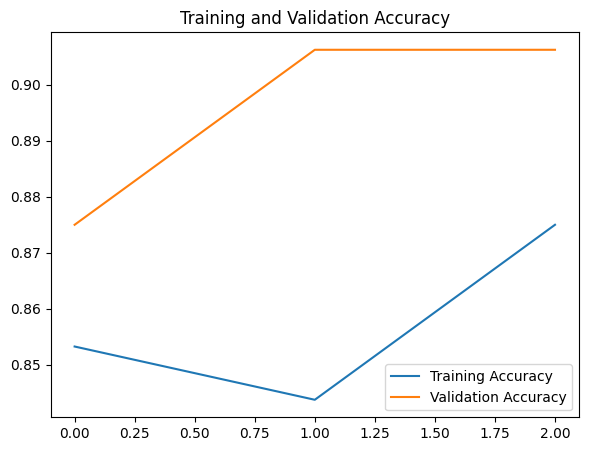

In [ ]:
# Plot the training history
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')


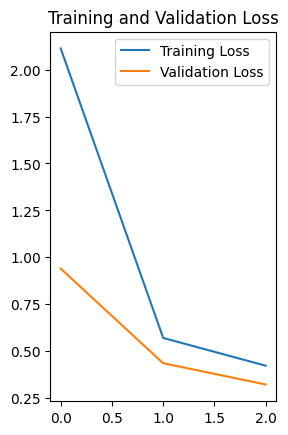

In [ ]:
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()